# 版本说明v4 #
1. 使用LinearRegressor
2. 使用pipeline
3. 添加自定义的Transformer，可以选择指定的成分
4. 针对各个参数进行了调优
5. 封装了工具方法

# 拆分训练集和验证集 #

In [78]:
from hw1_utils import *
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

X_train_full,y_train_full,X_test,test_option_index,test_options = load_data() # 加载训练和测试数据

X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,
                                                   y_train_full,
                                                   test_size=0.2) # 分割验证集和验证集
n_features = X_train.shape[1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 建立pipeline #

In [235]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

options = SelectTestOptionTransformer(test_option_index) # 选择测项特征的转化器
model = None
pipeline = Pipeline(steps=[('options',options),
                           ('scaler', StandardScaler()),
                           ('model' , model)])

search_utils = SearchUtils(pipeline,X_train_full,y_train_full)

## 使用LinearRegression模型 ##

In [236]:
from sklearn.model_selection import cross_val_score

pipeline.steps[2] = ('model',LinearRegression())

cross_val_score(pipeline,X_train_full,y_train_full).mean()

0.8443606921920231

# 剔除无关Feature #
1. 将所有feature放进去，计算cv_score，记录为best score
2. 然后分别减掉一个feature，选出最高的cv_score，如果，如果比best_score，那么去掉这个feature
3. 然后重复上面的操作，直到最高的score不再比best_score高为止。

In [237]:
pipeline.steps[2] = ('model',LinearRegression())
options.exclude = []

train_best_scores = []
valid_best_scores = []
exclude_params = []
best_score = 0
flag = True
while flag:
    param_range = [exclude_params + [test_options[i]] for i in range(18)]
    
    train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                                 'options__exclude',param_range)
    
    valid_score = valid_scores.mean(axis=1)              # 取验证集每个feature的平均分
    valid_max = valid_score.max()                        # 取出最高分
    valid_argmax = valid_score.argmax()                  # 最高分对应的feature值
    train_max = train_scores.mean(axis=1)[valid_argmax]  # 该feature在训练集的分数作为训练集最高分
    
    if valid_max > best_score:
        train_best_scores.append(train_max)
        valid_best_scores.append(valid_max)
        best_score = valid_max
        if len(valid_score) > 1:
            test_option_killed = test_options[valid_argmax]
            exclude_params.append(test_option_killed)
        print('剔除{}后，训练集得分为{:.4f}，验证集得分为{:.4f}'.format(
            test_option_killed,train_max,valid_max))
            
    else:
        print('剔除完成。')
        flag = False

剔除RH后，训练集得分为0.8826，验证集得分为0.8459
剔除THC后，训练集得分为0.8824，验证集得分为0.8466
剔除NMHC后，训练集得分为0.8822，验证集得分为0.8472
剔除AMB_TEMP后，训练集得分为0.8818，验证集得分为0.8479
剔除WIND_DIREC后，训练集得分为0.8815，验证集得分为0.8483
剔除NO2后，训练集得分为0.8812，验证集得分为0.8487
剔除WS_HR后，训练集得分为0.8810，验证集得分为0.8489
剔除WIND_SPEED后，训练集得分为0.8807，验证集得分为0.8492
剔除WD_HR后，训练集得分为0.8804，验证集得分为0.8494
剔除RAINFALL后，训练集得分为0.8801，验证集得分为0.8495
剔除CH4后，训练集得分为0.8795，验证集得分为0.8495
剔除完成。


In [167]:
exclude_params 

['RH',
 'THC',
 'NMHC',
 'AMB_TEMP',
 'WIND_DIREC',
 'NO2',
 'WS_HR',
 'WIND_SPEED',
 'WD_HR',
 'RAINFALL',
 'CH4']

In [170]:
valid_best_scores

[0.8458928052416193,
 0.8465658857667734,
 0.8472180038136082,
 0.8478696241065699,
 0.8483088469965182,
 0.8486776551720734,
 0.8489273441770215,
 0.8491832160605401,
 0.849413436958576,
 0.8494950728665771,
 0.8495024139932805]

In [175]:
train_best_scores

[0.8825598602446174,
 0.8823771158273139,
 0.8821632742422434,
 0.8818185465025833,
 0.8815265470784478,
 0.8811858669055083,
 0.880950170396131,
 0.8806664794354901,
 0.8804019823989597,
 0.8800917772013973,
 0.8795468026598325]

In [176]:
best_score

0.8495024139932805

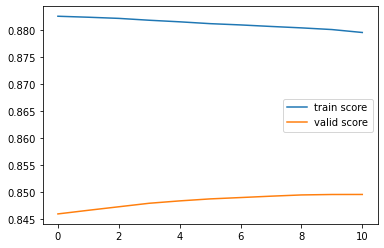

In [174]:
x = len(exclude_params)
plt.plot(range(x),train_best_scores,label='train score')
plt.plot(range(x),valid_best_scores,label='valid score')
plt.legend()
plt.show()

# 删除低方差Feature #

## 保存之前获得的结果 ##

In [177]:
exclude_params = ['RH',
 'THC',
 'NMHC',
 'AMB_TEMP',
 'WIND_DIREC',
 'NO2',
 'WS_HR',
 'WIND_SPEED',
 'WD_HR',
 'RAINFALL',
 'CH4']

valid_best_scores = [0.8458928052416193,
 0.8465658857667734,
 0.8472180038136082,
 0.8478696241065699,
 0.8483088469965182,
 0.8486776551720734,
 0.8489273441770215,
 0.8491832160605401,
 0.849413436958576,
 0.8494950728665771,
 0.8495024139932805]

train_best_scores = [0.8825598602446174,
 0.8823771158273139,
 0.8821632742422434,
 0.8818185465025833,
 0.8815265470784478,
 0.8811858669055083,
 0.880950170396131,
 0.8806664794354901,
 0.8804019823989597,
 0.8800917772013973,
 0.8795468026598325]

best_score = 0.8495024139932805

## 配置pipeline ##

In [238]:
from sklearn.feature_selection import VarianceThreshold
if(len(pipeline.steps) == 3):
    pipeline.steps.insert(1,('variance',VarianceThreshold()))

options.exclude = exclude_params

pipeline.steps[3] = ('model',LinearRegression())
pipeline.steps

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.6s finished


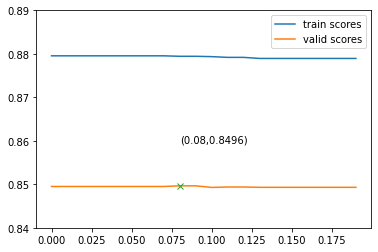

In [251]:
treshold_range = [0.01 * i for i in range(20)]

history = search_utils.search('variance__threshold',treshold_range,ylim=(.84,.89))

In [244]:
pipeline.fit(X_train_full,y_train_full)

train_rmse = mean_squared_error(pipeline.predict(X_train),y_train)**0.5
valid_rmse = mean_squared_error(pipeline.predict(X_valid),y_valid)**0.5
print("训练集的RMSE:{:.5f}".format(train_rmse))
print("验证集的RMSE:{:.5f}".format(valid_rmse))
print("验证集的score:{:.5f}".format(pipeline.score(X_valid,y_valid)))

训练集的RMSE:5.76702
验证集的RMSE:5.68746
验证集的score:0.89076


## 使用XGBRegression模型 ##
**结果**：不如LinearRegression效果好

In [17]:
from xgboost import XGBRegressor

pipeline.steps[2] = ('model',XGBRegressor())

cross_val_score(pipeline,X_train_full,y_train_full).mean()

0.7976042823872349

### 只用PM2.5预测 ###

In [19]:
pipeline.steps[2] = ('model',XGBRegressor())

options.exclude = test_option_index.keys() - ['PM2.5']

cross_val_score(pipeline,X_train_full,y_train_full).mean()

0.7844160654527942

## 使用随机森林 ##

In [22]:
from sklearn.ensemble import RandomForestRegressor

pipeline.steps[2] = ('model',RandomForestRegressor())

cross_val_score(pipeline,X_train_full,y_train_full).mean()

0.8031992234656545

In [31]:
pipeline.steps[2] = ('model',RandomForestRegressor(verbose=1))

history = search_utils.search('options__exclude_index',range(18))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
pipeline.fit(X_train,y_train)

train_rmse = mean_squared_error(pipeline.predict(X_train),y_train)**0.5
valid_rmse = mean_squared_error(pipeline.predict(X_valid),y_valid)**0.5
print("训练集的RMSE:{:.5f}".format(train_rmse))
print("验证集的RMSE:{:.5f}".format(valid_rmse))
print("验证集的score:{:.5f}".format(pipeline.score(X_valid,y_valid)))

In [ ]:
history = search('options__exclude_index',range(18))

In [ ]:
scores_valid = history[3]
scores_mean_valid = scores_valid.mean(axis=1)
exclude = [test_options[i] for i,score in zip(range(18),scores_mean_valid)
                                            if score > score_base]
exclude

In [ ]:
test_option_index.keys() - exclude

## 只评估PM2.5 ##
**总结**：效果比所有的数据差

In [ ]:
options.exclude = test_option_index.keys() - ['PM2.5'] # 从所有测项中删除PM2.5

cross_val_score(pipeline,X_train,y_train).mean()

# 去掉噪音 #
**总结**：准确率提升

In [ ]:
options.exclude = exclude
options.exclude_index = None

cross_val_score(pipeline,X_train,y_train).mean()

In [ ]:
options.exclude = exclude
options.exclude.append('O3')
options.exclude_index = None

cross_val_score(pipeline,X_train,y_train).mean()

去掉一些气体

In [ ]:
options.exclude = ['CH4','CO','NO','NO2','SO2','O3']
options.exclude_index = None

cross_val_score(pipeline,X_train,y_train).mean()

# 训练模型 #

In [ ]:
options.exclude = exclude
options.exclude_index = None

pipeline.fit(X_train,y_train)

train_rmse = mean_squared_error(pipeline.predict(X_train),y_train)**0.5
valid_rmse = mean_squared_error(pipeline.predict(X_valid),y_valid)**0.5
print("训练集的RMSE:{:.5f}".format(train_rmse))
print("验证集的RMSE:{:.5f}".format(valid_rmse))
print("验证集的score:{:.5f}".format(pipeline.score(X_valid,y_valid)))

# 输出数据 #

In [ ]:
pipeline.fit(X_train_pd,y_train_full)

preds_train_full = pipeline.predict(X_train_pd)
print('训练集的RMSE:{:.5f}'.format(mean_squared_error(preds_train_full,y_train_full)**0.5))

preds_test = pipeline.predict(X_test_pd)
ids = ['id_' + str(i) for i in range(len(X_test_pd))]
output = pd.DataFrame({'id':ids,
                       'value':preds_test})
output.to_csv('output/pm25_submission.csv',index=False)